In [1]:
import json,os,shutil,yaml,torch
import torch.nn as nn
import h5py
import numpy as np

from models import create_model
from utils.train import train_model, test_model
from utils.util import get_optimizer, get_loss, get_scheduler
from utils.data_container import get_data_loader
from utils.preprocess import  preprocessing_for_metric


con = 'evoconv2-config'
data_category = ['bike']
with open(os.path.join('config', f'{con}.yaml')) as f:
    conf = yaml.safe_load(f)

#print(json.dumps(conf, indent=4))

#os.environ["CUDA_VISIBLE_DEVICES"] = str(conf['device'])
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)
device = torch.device(0)

model_name = conf['model']['name']
data_set = dataset = conf['data']['dataset']

data = list()
for i,category in enumerate(data_category):
    with h5py.File(f"data/{dataset}/{category}_data.h5", 'r') as hf:
        data_pick = hf[f'{category}_pick'][:]
    with h5py.File(f"data/{dataset}/{category}_data.h5", 'r') as hf:
        data_drop = hf[f'{category}_drop'][:]
    data.append(np.stack([data_pick, data_drop], axis=2))
    data = np.concatenate(data, axis=1)
    
data.shape

(4368, 250, 2)

In [2]:
from workalendar.usa.new_york import NewYork
holidays = [NewYork().holidays(y) for y in [2016]][0]
holidays

[(datetime.date(2016, 1, 1), 'New year'),
 (datetime.date(2016, 1, 18), 'Birthday of Martin Luther King, Jr.'),
 (datetime.date(2016, 2, 12), "Lincoln's Birthday"),
 (datetime.date(2016, 2, 15), "Washington's Birthday"),
 (datetime.date(2016, 5, 30), 'Memorial Day'),
 (datetime.date(2016, 7, 4), 'Independence Day'),
 (datetime.date(2016, 9, 5), 'Labor Day'),
 (datetime.date(2016, 10, 10), 'Columbus Day'),
 (datetime.date(2016, 11, 8), 'Election Day'),
 (datetime.date(2016, 11, 11), 'Veterans Day'),
 (datetime.date(2016, 11, 24), 'Thanksgiving Day'),
 (datetime.date(2016, 12, 25), 'Christmas Day'),
 (datetime.date(2016, 12, 26), 'Christmas Day (Observed)')]

In [3]:
val_len, test_len = conf['data']['_len']
X_list = conf['data']['X_list']
Y_list = conf['data']['Y_list']
conf['data']

{'dataset': 'nogrid',
 'batch_size': 32,
 'X_list': [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
 'Y_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 '_len': [672, 672],
 'Normal_Method': 'Standard'}

In [4]:
# compute historical averages only for train data
speed_sum = np.zeros((data.shape[1],7,2*24,2)) # the last dimension is 2 because it holds pickups and dropoffs
speed_sum_sq = np.zeros((data.shape[1],7,2*24,2))
counts = np.zeros((data.shape[1],7,2*24,2))
num_train = len(data)-val_len-test_len
print("data size for computing historical averages:", num_train)
for i in range(num_train):
    day = int(i / (2*24))
    weekday = int((day+5) % 7) # adjust with +5, because April 2016 starts on a Friday (and 0 is Sunday)
    if day == 59: # these are holidays (Memorial Day)
        weekday = 0 # treat holidays as sundays (weekday = 0)
    tod = int(i % (2*24))
    #print(day, weekday, tod)
    speed_sum[:,weekday,tod,:] += data[i,:,:]
    speed_sum_sq[:,weekday,tod,:] += (data[i,:,:]**2)
    counts[:,weekday,tod,:] += 1.0
    
historical_avg = speed_sum / counts
historical_std = np.sqrt(0.1+(speed_sum_sq / counts) - (historical_avg**2))

data size for computing historical averages: 3024


In [3]:
672/(24*2)

14.0

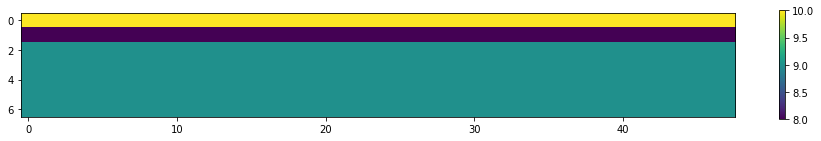

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,2))
plt.imshow(counts[0,:,:,0])
plt.colorbar();

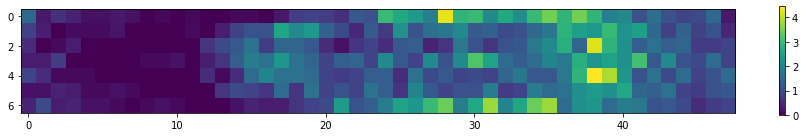

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,2))
plt.imshow(historical_avg[0,:,:,0])
plt.colorbar();

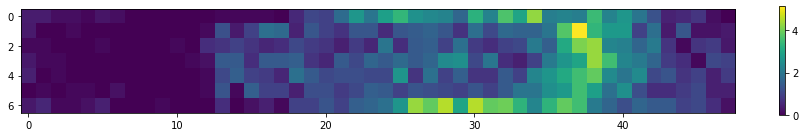

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,2))
plt.imshow(historical_avg[0,:,:,1])
plt.colorbar();

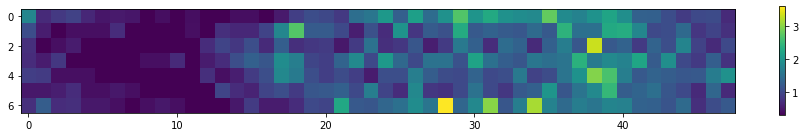

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,2))
plt.imshow(historical_std[0,:,:,0])
plt.colorbar();

In [13]:
# compute residuals of historical averages
trues_train = []
preds_train_ha = []
#for i in range((n_train+n_val)*12*24):
for i in range(num_train):
    day = int(i / (2*24))
    weekday = int((day+5) % 7) # adjust with +5, because April 2016 starts on a Friday (and 0 is Sunday)
    if day == 59: # these are holidays (Memorial Day)
        weekday = 0 # treat holidays as sundays (weekday = 0)
    tod = int(i % (2*24))
    preds_train_ha.append(historical_avg[:,weekday,tod,:])
    trues_train.append(data[i,:,:])
    
trues_train = np.array(trues_train)
print(trues_train.shape)
preds_train_ha = np.array(preds_train_ha)
print(preds_train_ha.shape)

from math_utils import evaluation
evl_train = evaluation(trues_train, preds_train_ha, {"mean": 0, "std": 1})
print('Trainset Residuals (pickups and dropoffs) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 
evl_train = evaluation(trues_train[:,:,:1], preds_train_ha[:,:,:1], {"mean": 0, "std": 1})
print('Trainset Residuals (pickups) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 
evl_train = evaluation(trues_train[:,:,1:], preds_train_ha[:,:,1:], {"mean": 0, "std": 1})
print('Trainset Residuals (dropoffs) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 

(3024, 250, 2)
(3024, 250, 2)
Trainset Residuals (pickups and dropoffs) -> MAPE: 24862.449; MAE:  1.315; RMSE: 2.165
Trainset Residuals (pickups) -> MAPE: 25512.395; MAE:  1.344; RMSE: 2.240
Trainset Residuals (dropoffs) -> MAPE: 24212.502; MAE:  1.286; RMSE: 2.088


In [14]:
# compute predictions based on historical averages for entire dataset
trues = []
preds_ha = []
for i in range(len(data)):
    trues.append(data[i,:,:])
    day = int(i / (2*24))
    weekday = int((day+5) % 7) # adjust with +5, because April 2016 starts on a Friday (and 0 is Sunday)
    if day == 59: # these are holidays (Memorial Day)
        weekday = 0 # treat holidays as sundays (weekday = 0)
    tod = int(i % (2*24))
    preds_ha.append(historical_avg[:,weekday,tod,:])
    
trues = np.array(trues)
preds_ha = np.array(preds_ha)
print(preds_ha.shape)

(4368, 250, 2)


In [15]:
from utils.data_container import traffic_demand_prediction_dataset

#add time window
X_, Y_ = list(), list()
X_ha, Y_ha = list(), list()
for i in range(max(X_list), data.shape[0] - max(Y_list)):
    X_.append([data[i - j] for j in X_list])
    Y_.append([data[i + j] for j in Y_list])
    X_ha.append([preds_ha[i - j] for j in X_list])
    Y_ha.append([preds_ha[i + j] for j in Y_list])
X_ = np.asarray(X_)
Y_ = np.asarray(Y_)
X_ha = np.asarray(X_ha)
Y_ha = np.asarray(Y_ha)

#split dataset by days or by ratio

x_tra, y_tra = X_[:(-val_len-test_len)], Y_[:(-val_len-test_len)]
x_val, y_val = X_[(-val_len-test_len):(-test_len)], Y_[(-val_len-test_len):(-test_len)]
x_test, y_test = X_[(-test_len):], Y_[(-test_len):]
print('Train: ', x_tra.shape, y_tra.shape)
print('Val: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)
x_tra_ha, y_tra_ha = X_ha[:(-val_len-test_len)], Y_ha[:(-val_len-test_len)]
x_val_ha, y_val_ha = X_ha[(-val_len-test_len):(-test_len)], Y_ha[(-val_len-test_len):(-test_len)]
x_test_ha, y_test_ha = X_ha[(-test_len):], Y_ha[(-test_len):]
print('Train HA: ', x_tra_ha.shape, y_tra_ha.shape)
print('Val HA: ', x_val_ha.shape, y_val_ha.shape)
print('Test HA: ', x_test_ha.shape, y_test_ha.shape)

Train:  (3001, 12, 250, 2) (3001, 12, 250, 2)
Val:  (672, 12, 250, 2) (672, 12, 250, 2)
Test:  (672, 12, 250, 2) (672, 12, 250, 2)
Train HA:  (3001, 12, 250, 2) (3001, 12, 250, 2)
Val HA:  (672, 12, 250, 2) (672, 12, 250, 2)
Test HA:  (672, 12, 250, 2) (672, 12, 250, 2)


In [25]:
from math_utils import evaluation

steps_ahead = -1

evl_val = evaluation(y_val[:,steps_ahead,:,:], y_val_ha[:,steps_ahead,:,:], {"mean": 0, "std": 1})
print('Validation set (pickups and dropoffs) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 
evl_val = evaluation(y_val[:,steps_ahead,:,:1], y_val_ha[:,steps_ahead,:,:1], {"mean": 0, "std": 1})
print('Validation set (pickups) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 
evl_val = evaluation(y_val[:,steps_ahead,:,1:], y_val_ha[:,steps_ahead,:,1:], {"mean": 0, "std": 1})
print('Validation set (dropoffs) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 

evl_test = evaluation(y_test[:,steps_ahead,:,:], y_test_ha[:,steps_ahead,:,:], {"mean": 0, "std": 1})
print('Test set (pickups and dropoffs) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 
evl_test = evaluation(y_test[:,steps_ahead,:,:1], y_test_ha[:,steps_ahead,:,:1], {"mean": 0, "std": 1})
print('Test set (pickups) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 
evl_test = evaluation(y_test[:,steps_ahead,:,1:], y_test_ha[:,steps_ahead,:,1:], {"mean": 0, "std": 1})
print('Test set (dropoffs) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Validation set (pickups and dropoffs) -> MAPE: 21825.662; MAE:  1.626; RMSE: 2.699
Validation set (pickups) -> MAPE: 22643.681; MAE:  1.671; RMSE: 2.829
Validation set (dropoffs) -> MAPE: 21007.643; MAE:  1.580; RMSE: 2.561
Test set (pickups and dropoffs) -> MAPE: 17446.485; MAE:  1.726; RMSE: 2.871
Test set (pickups) -> MAPE: 17912.127; MAE:  1.764; RMSE: 2.977
Test set (dropoffs) -> MAPE: 16980.842; MAE:  1.688; RMSE: 2.761


In [57]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    if not loc % 50:
        print(loc)
    
    loc_preds = []
    loc_trues = []
    for steps_ahead in range(12):
        x1 = x_tra[:, :, loc, 0] - x_tra_ha[:, :, loc, 0]
        y1 = y_tra[:, steps_ahead, loc, 0] - y_tra_ha[:, steps_ahead, loc, 0]
        reg1 = LinearRegression()
        #reg = Lasso(alpha=0.1)
        #reg = GradientBoostingRegressor(random_state=0)
        reg1.fit(x1, y1)
        trues1 = y_test[:, steps_ahead, loc, 0]
        preds1 = reg1.predict(x_test[:, :, loc, 0] - x_test_ha[:, :, loc, 0]) + y_test_ha[:, steps_ahead, loc, 0]

        x2 = x_tra[:, :, loc, 1] - x_tra_ha[:, :, loc, 1]
        y2 = y_tra[:, steps_ahead, loc, 1] - y_tra_ha[:, steps_ahead, loc, 1]
        reg2 = LinearRegression()
        #reg = Lasso(alpha=0.1)
        #reg = GradientBoostingRegressor(random_state=0)
        reg2.fit(x2, y2)
        trues2 = y_test[:, steps_ahead, loc, 1]
        preds2 = reg2.predict(x_test[:, :, loc, 1] - x_test_ha[:, :, loc, 0]) + y_test_ha[:, steps_ahead, loc, 1]

        loc_preds.append([preds1, preds2])
        loc_trues.append([trues1, trues2])

    all_preds.append(loc_preds)
    all_trues.append(loc_trues)

all_preds = np.array(all_preds).transpose([3,0,2,1])
print(all_preds.shape)
all_trues = np.array(all_trues).transpose([3,0,2,1])
print(all_trues.shape)

evl_test = evaluation(all_trues.reshape([all_trues.shape[0],all_trues.shape[1],12*2]), 
                      all_preds.reshape([all_trues.shape[0],all_trues.shape[1],12*2]), 
                      {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

0
50
100
150
200
(672, 250, 2, 12)
(672, 250, 2, 12)
Test set -> MAPE: 24922.866; MAE:  1.738; RMSE: 2.758


In [ ]:
# confirm that real model (neural net) is worse

In [81]:
folder = os.path.join('save', conf['name'], f'{data_set}_{"".join(data_category)}', conf['tag'])
folder

'save/Evoconv2/nogrid_bike/train1'

In [82]:
predictions = np.load(os.path.join(folder, 'test-results.npz'))["predictions"]
running_targets = np.load(os.path.join(folder, 'test-results.npz'))["targets"]
print(predictions.shape)
print(running_targets.shape)

(672, 12, 250, 2)
(672, 12, 250, 2)


In [83]:
_, normal = get_data_loader(**conf['data'], data_category=data_category, device=device,
                                          model_name=model_name)

predictions = normal[0].inverse_transform(predictions)
running_targets = normal[0].inverse_transform(running_targets)


std: 4.010208024889097 mean: 2.7760608974358973


In [85]:
evl_test = evaluation(predictions.transpose([0,2,1,3]).reshape([all_trues.shape[0],all_trues.shape[1],12*2]), 
                      running_targets.transpose([0,2,1,3]).reshape([all_trues.shape[0],all_trues.shape[1],12*2]), 
                      {"mean": 0, "std": 1})
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Test set -> MAPE: 0.956; MAE:  1.767; RMSE: 2.885
